In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV # cross_val_score ekledim
from sklearn.linear_model import Lasso
import math
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score 
from sklearn import linear_model
from sklearn import decomposition, datasets
from sklearn.linear_model import LassoCV
#from yellowbrick.datasets import load_concrete
#from yellowbrick.regressor import AlphaSelection
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

In [2]:
numberofProducts=10
numberofCluster=3

In [3]:
data_full = pd.read_csv("A.csv")
data = data_full[["product_id","sales", "price", "basket", "fav", "visit", "impression", "stock", "demand", "removeFromFav", "reviewCount", "rating"]]

In [4]:
dateData = pd.read_csv("specialDates.csv")
for column in dateData.columns:
    data[column]=np.tile(dateData[column].to_numpy(),3415) 
data

<ipython-input-4-a1f5d675e840>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column]=np.tile(dateData[column].to_numpy(),3415)


,product_id,sales,price,basket,fav,visit,impression,stock,demand,removeFromFav,reviewCount,rating,haftasonu,kampanya,resmitatil,ozelGun,Ozel3,Ozel5
0,207940697241116,2,119.00,11,0,81,0,0,0,0,0,0.0,0,0,0,0,0,0
1,207940697241116,5,119.00,19,0,124,0,0,0,4,0,0.0,0,0,0,0,0,0
2,207940697241116,8,119.00,34,0,224,0,0,0,5,0,0.0,1,0,0,0,0,0
3,207940697241116,18,119.00,61,0,379,980,0,0,6,0,0.0,1,0,0,0,0,0
4,207940697241116,17,119.00,81,0,509,1660,0,0,10,2,5.0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706900,2465458815060489,0,3.89,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0
706901,2465458815060489,0,3.89,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0
706902,2465458815060489,0,3.89,0,0,2,0,0,0,0,0,0.0,0,0,0,0,0,0
706903,2465458815060489,0,3.89,0,0,0,0,0,0,0,0,0.0,1,0,0,0,0,0


In [5]:
# Returns logarithmic range between start power to end power
# Alternative to np.logspace(10e-5, 10, 100, endpoint=True)
def log_range(start,end):
    lst = []
    for i in range(start-end+1):
        power = start - i
        unit = 10**power
        for j in range(9):
            lst.append(unit*(j+1))
    return lst

In [6]:
alpha_search_range = log_range(2, -8)
def searching(X, y):
    ## en iyi alpha değer için araştırma yapıyor
    pipeline = Pipeline([
                         ('scaler',StandardScaler()),
                         ('model',Lasso())
        ])
    
    #Searching for best alpha
    search = GridSearchCV(pipeline,
                        {'model__alpha':alpha_search_range}, # burayı nasıl değiştireceğimi anlamadım tam
                        scoring="neg_mean_squared_error",verbose=0
                        )
    #fit model
    search.fit(X,y)
    coefficients = search.best_estimator_.named_steps['model'].coef_
    #print(search.best_estimator_,"AAAAAAAAAAAAAAAAAAAAAAAAAAAAA")
    return (search.best_estimator_.named_steps['model'].get_params()['alpha'], coefficients) 

In [7]:
def regression(metrics, X_train, y_train, X_test, y_test):
    productLasso = []
    for metric in metrics:
        alph= metric[0] # burada en uygun alpha değerine göre lasso yapıyor ve sonuçları alıyor 
        lasso= Lasso(alpha=alph)
        lasso.fit(X_train, y_train)
        y_train_pred= lasso.predict(X_train)
        y_test_pred= lasso.predict(X_test)
        productLasso.append((mean_absolute_percentage_error(y_train,y_train_pred), mean_absolute_percentage_error(y_test,y_test_pred)))
    return productLasso

In [8]:
col_names = []
X_test=[]
y_test=[]
def manipulation_and_search(data, max_lag = 7, num_prod = numberofProducts):
    metrics = []
    count = 0 ## kaç ürün için lasso yapılacak diye tutuldu

    for product in data["product_id"].unique():
        
        count += 1
        prodData = data[data.product_id == product]   
        #Productlasso = {}
        #productLasso=[]
        for column in prodData.columns:
            if column in ['haftasonu', 'kampanya', 'resmitatil', 'ozelGun', 'Ozel3', 'Ozel5']: continue
            for lag in range(1, max_lag+1):
                name = f"{column}({lag})"
                prodData[name] = prodData[column].shift(lag)
                """
                alphas = np.logspace(-10, 1, 400)
                # Instantiate the linear model and visualizer
                model = LassoCV(alphas=alphas)
                visualizer = AlphaSelection(model)
                visualizer.fit(X, y)
                visualizer.show()
                """
        X=prodData.iloc[max_lag:, 2:]
        if count == 1 : 
            global col_names 
            col_names = X.columns # get column names
        y = prodData["sales"][:-max_lag]
        # buradaki X_test ve y_test sonradan kullanılabilir şekilde değil, 
        X_testa,X_train = np.split(X, [int(.2*len(X))])
        y_testb,y_train = np.split(y, [int(.2*len(y))])
        X_test.append(X_testa)
        y_test.append(y_testb)

        results = searching(X_train, y_train)
        metrics.append(results)

        if count == num_prod: # burada ürün sayısı belirtilecek
                break        
    
        
    return metrics, X_train, y_train, X_test, y_test

In [9]:
import time
start = time.perf_counter()
metrics, X_train, y_train, X_test, y_test = manipulation_and_search(data)
end = time.perf_counter()
print("It took ", (end-start)/60)

<ipython-input-8-4db2171b0fb3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag)
<ipython-input-8-4db2171b0fb3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prodData[name] = prodData[column].shift(lag)
<ipython-input-8-4db2171b0fb3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4982.598777574859, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4482.738853842595, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4855.052285881002, tolerance: 995.7876468750001
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packa

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 424.5758412786754, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1753.9708660391836, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1540.1012210570152, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-package

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1280.8256080508743, tolerance: 927.83144296875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 731.9976340992678, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2501.173614318962, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packag

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1660.842906478843, tolerance: 995.7876468750001
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 393.774496160414, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1684.9328905340226, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packa

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1404.7717859422057, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1619.0118601363772, tolerance: 995.7876468750001
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364.0050914384278, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packa

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.143349360375, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1615.0460766010845, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1402.130276081726, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.5929671573556, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1616.032304919727, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1403.1035194506908, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1402.0746599714714, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1616.8630918479082, tolerance: 995.7876468750001
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.1240748539254, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packa

/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.08231254469314, tolerance: 258.822996875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1614.912216097576, tolerance: 974.22132421875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1401.998187434822, tolerance: 984.572796875
  model = cd_fast.enet_coordinate_descent(
/Users/metehangelgi/opt/anaconda3/lib/python3.8/site-packages

It took  2.4606330138


In [10]:
metrics

[(0.05,
  array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
          0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  5.12951584e+02,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.99964119e-03,
         -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000

In [31]:
maeA=[]
mapeA=[]
for i in range(numberofProducts):
    
    params = metrics[i][1]
    tst = X_test[i].to_numpy()
    prediction = tst.dot(np.array(params))
    mae = mean_absolute_error(y_test[i], prediction)
    mape = mean_absolute_percentage_error(y_test[i], prediction)
    nzero_index = np.nonzero(params)[0]
    param_names = col_names[nzero_index]
    #print(param_names,mae,mape)
    maeA.append(mae)
    mapeA.append(mape)

    #print(prediction-y_test, y_test)

In [14]:
#metric extraction
coefficients = []
for metric in metrics:
    coefficients.append(metric[1])
coeff2 = coefficients[:]

In [15]:
coeff2

[array([ 0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
         0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.12951584e+02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  4.99964119e-03,
        -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.0

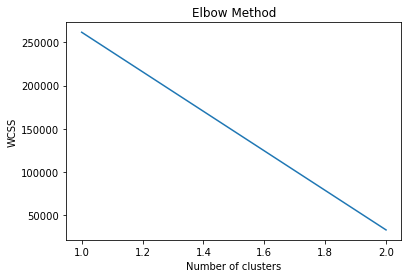

In [16]:
wcss = []
for i in range(1, numberofCluster):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    # coeff2 2D array bekliyor 
    kmeans.fit(coeff2)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, numberofCluster), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [17]:
kmeans = KMeans(n_clusters=numberofCluster, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(coeff2)
"""
plt.scatter(np.array(coeff2)[:, 1], np.array(coeff2)[:, -1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()
"""

"\nplt.scatter(np.array(coeff2)[:, 1], np.array(coeff2)[:, -1])\nplt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')\nplt.show()\n"

In [18]:
kmeans.cluster_centers_

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.68788609e-02,  2.56539397e+02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.32434000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+0

In [19]:
# buradan hangi ürün hangi clustera konulmuş anlaşılıyor
kmeans.labels_

array([2, 1, 1, 1, 1, 0, 1, 1, 1, 1], dtype=int32)

In [37]:
produt_ids=data["product_id"].unique()[:10]
produt_ids=np.char.mod('%d', produt_ids)
clusterLabels=kmeans.labels_
produt_ids=np.array(produt_ids)
clusterLabels=np.array(clusterLabels)
maeA=np.array(maeA)
mapeA=np.array(mapeA)
lis=np.array([produt_ids, clusterLabels, maeA, mapeA])
outputDF=pd.DataFrame(data = np.transpose(lis), columns=['product_id','label','mae','mape'])
outputDF

,product_id,label,mae,mape
0,207940697241116,2,344005.69896375656,512.041479614966
1,1500213079802801,1,12.156494475812497,13815694764888.297
2,684587466171915,1,30.997273090097007,174449772310685.84
3,4445491431117742,1,607.8900402583726,10.07351855679129
4,1138421777673592,1,202.05566999783863,7.165094680774419
5,2765821603728117,0,34862.036653047835,261.0818374178217
6,2723917323057815,1,648.5084711629519,10.322458753091157
7,3061310424737206,1,1.9124803278753721,18974823728057.94
8,949653557332511,1,0.27429644413366167,0.16457786648019695
9,3427531672541938,1,19.765257715537572,2.343219698029349


In [ ]:
# en son bu şekilde basılabilir istedğimiz buysa. 
filename="A-LassoCluster.csv"
outputDF.to_csv(filename, sep=',',header=True)

In [ ]:
"""
reg_res = regression(metrics, X_train, y_train, X_test, y_test)
print(reg_res)
sum = 0
for reg in reg_res:
    sum += reg[1]
sum / len(reg_res)
"""

In [ ]:
"""
labels = ["trainMAE","testMAE","price", "basket", "fav", "visit", "impression", "stock", "demand", "removeFromFav", "reviewCount", "rating","haftasonu","kampanya","resmitatil","ozelGun","Ozel3","Ozel5"]
WholeLasso=lasso(data)
WholeLasso=pd.DataFrame(WholeLasso, columns=labels)
WholeLasso
"""

In [ ]:
"""
filename="A-Lasso.csv"
WholeLasso.to_csv(filename, sep=',',header=True)
"""